<h1> <center> EL7006 - Tarea Nº2 <br /> Information-Theoretic Learning  </center> </h1>
<h3> <center>Profesor: Pablo Estévez <br />
Profesor Auxiliar: Nicolás Astorga <br />
Ayudantes: Bastían Gamboa, John Intriago <br />
<h3><center>Semestre: Primavera 2022 </center></h3>

En esta tarea deberán contestar preguntas e implementar código relacionado a information-theoretic learning (ITL).

Para entregar su tarea, suba a u-cursos un archivo zip que contenga los notebooks de los problemas 1 y 2, desarrollados con sus respuestas e implementaciones, junto con cualquier archivo adicional necesario para ejecutarlos. Sea claro en sus respuestas, y comente adecuadamente su código. No es necesario redactar un informe.

<h1><center><u>Problema 2: Descomposición de señales por máxima entropía</u></center></h1>

Suponga que tiene tres fuentes de información $s_1(t)$, $s_2(t)$ y $s_3(t)$. Tres sensores miden dichas fuentes con interferencias, entregándole tres mediciones $x_1(t)$, $x_2(t)$ y $x_3(t)$. Se desea recuperar las fuentes originales de información a partir de las mediciones. Para una interferencia lineal, la situación anterior se describe matemáticamente como:
$$ 
\begin{bmatrix} x_1(t) \\ x_2(t) \\ x_3(t) \end{bmatrix} = 
\mathbf{A}\begin{bmatrix} s_1(t) \\ s_2(t) \\ s_3(t) \end{bmatrix} + \nu,
$$
donde $\mathbf{A}\in\mathbb{R}^{3\times 3}$ es una matriz de mezcla dependiente de los sensores y $\nu$ es un ruido gaussiano independiente. Este problema es popularmente conocido como "cocktail party problem". Se puede resolver usando el algoritmo ICA (Independent Component Analysis), que asume que las señales $s_{1}(t)$, $s_{2}(t)$ y $s_{3}(t)$ son estadísticamente independientes. Por lo tanto, ICA encuentra una matriz $\mathbf{B}$ que reconstruye componentes $\hat{s}(t)=\mathbf{B}x (t)$ de máxima independencia, por ejemplo al maximizar la entropía de las salidas. En este sentido, $\mathbf{B}$ busca aproximar $\mathbf{A}^{-1}$. En general, por la ambigüedad del problema, $\hat{s}(t)$ aproxima una versión escalada y permutada de $s(t)$.

El objetivo de este problema consiste en implementar y entrenar un modelo de descomposición que maximice la ECR (Entropía Cuadrática de Rényi). Este modelo tiene por finalidad descomponer las mediciones $x_{1}(t)$, $x_{2}(t)$ y $x_{3}(t)$ en las señales originales $s_{1}(t)$, $s_{2}(t)$ y $s_{3}(t)$ de forma semejante a ICA.

In [1]:
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import FastICA, PCA

<h2>Fuentes</h2>

El planteamiento típico del problema de separación de fuentes involucra múltiples grabaciones de varias personas hablando al mismo tiempo --de ahí el nombre "cocktail party problem". Sin embargo, para esta tarea se utilizarán imágenes como fuentes de información. En específico, se utilizan tres imágenes de 32 por 32 pixeles de la base de datos CIFAR10. Los pixeles toman valores en el intervalo $[0, 1]$ y son transformados a escala de grises por simplicidad.

/tmp/ipykernel_563540/2570902858.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = [imread(img) for img in imgs]


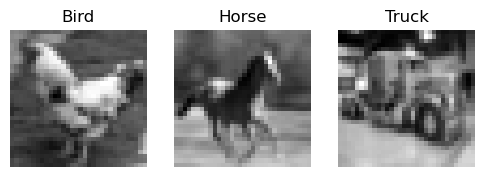

In [2]:
def rgb2gray(rgb_img):
    rgb_img = rgb_img.astype(np.float32) / 255.0  # Pixels in [0, 1] range
    gray_img = 0.299 * rgb_img[..., 0] + 0.587 * rgb_img[..., 1] + 0.114 * rgb_img[..., 2]
    return gray_img


imgs = ['image_1.png', 'image_2.png', 'image_3.png']
imgs = [imread(img) for img in imgs]
imgs = [rgb2gray(img) for img in imgs]

fig, axes = plt.subplots(1, 3, figsize=(6, 2), dpi=100)
for ax, img, title in zip(axes, imgs, ["Bird", "Horse", "Truck"]):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")
plt.show()

Estas imágenes son aplanadas en un vector y estandarizadas (media cero y varianza unitaria) para formar tres señales de $T=1024$ muestras cada una. Estas señales unidimensionales serán las fuentes de información $s_1(t)$, $s_2(t)$ y $s_3(t)$ a utilizar. Para su uso en los algoritmos posteriores, todas las muestras de las fuentes son concatenadas en una matriz $\mathbf{S}\in\mathbb{R}^{T\times 3}$ dada por:
$$ \mathbf{S} = \begin{bmatrix}
s_1(1) & s_2(1) & s_3(1) \\
s_1(2) & s_2(2) & s_3(2) \\
\vdots & \vdots & \vdots \\
s_1(T) & s_2(T) & s_3(T) 
\end{bmatrix} $$

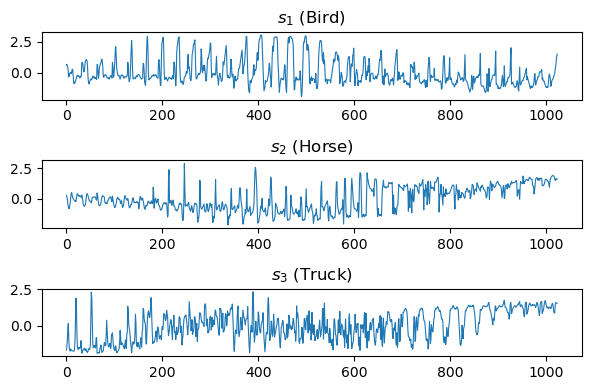

In [3]:
sources = [img.flatten() for img in imgs]  # vectors of length T = 32*32
sources = np.stack(sources, axis=1)  # matrix T x 3
sources = (sources - sources.mean(axis=0)) / sources.std(axis=0)  # standardize

fig, axes = plt.subplots(3, 1, figsize=(6, 4), dpi=100)
for ax, source, title in zip(axes, sources.T, ["$s_1$ (Bird)", "$s_2$ (Horse)", "$s_3$ (Truck)"]):
    ax.plot(source, linewidth=0.8)
    ax.set_title(title)
plt.tight_layout()
plt.show()

<h2>Mediciones</h2>

Las mediciones en cada instante están dadas por el siguiente modelo de mezcla con $\nu$ un ruido gaussiano de desviación estándar 0.01:
$$
\mathbf{A} = \begin{bmatrix} 1 & 1 & 1 \\ 0.5 & 2 & 1 \\ 1.5 & 1 & 2 \end{bmatrix},
\hspace{1.5cm}
\begin{bmatrix} x_1(t) \\ x_2(t) \\ x_3(t) \end{bmatrix} = \mathbf{A}
\begin{bmatrix} s_1(t) \\ s_2(t) \\ s_3(t) \end{bmatrix} + \nu.
$$
Todas las mediciones u observaciones forman una matriz $\mathbf{X}\in\mathbb{R}^{T\times 3}$ dada por:
$$ \mathbf{X} = \begin{bmatrix}
x_1(1) & x_2(1) & x_3(1) \\
x_1(2) & x_2(2) & x_3(2) \\
\vdots & \vdots & \vdots \\
x_1(T) & x_2(T) & x_3(T) 
\end{bmatrix} = \mathbf{S}\mathbf{A}^\top + \mathbf{N}$$
Luego de calculadas, estas mediciones son estandarizadas para su uso en los algoritmos.

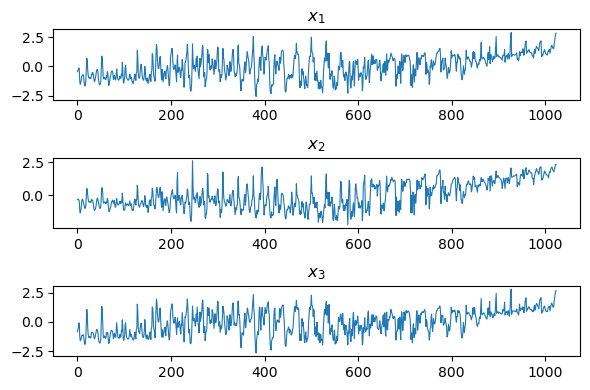

In [4]:
noise = np.random.RandomState(seed=0).normal(scale=0.01, size=sources.shape)  # Gaussian noise
A = np.array([[1, 1, 1], [0.5, 2, 1], [1.5, 1, 2]])  # Mixing matrix
samples = np.matmul(sources, A.T) + noise  # Generate observations
samples = samples.astype(np.float32)  # To save memory
samples = (samples - samples.mean(axis=0)) / samples.std(axis=0)  # standardize

fig, axes = plt.subplots(3, 1, figsize=(6, 4), dpi=100)
for ax, sample, title in zip(axes, samples.T, ["$x_1$", "$x_2$", "$x_3$"]):
    ax.plot(sample, linewidth=0.8)
    ax.set_title(title)
plt.tight_layout()
plt.show()

Las señales unidimensionales se pueden volver a convertir en una imagen para su visualización. Las tres señales de medición generadas anteriormente corresponden a las siguientes imágenes. Se verifica que las fuentes de información originales se encuentran mezcladas.

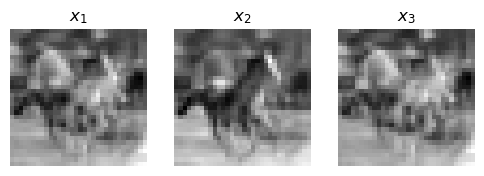

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2), dpi=100)
for ax, sample, title in zip(axes, samples.T, ["$x_1$", "$x_2$", "$x_3$"]):
    ax.imshow(sample.reshape(32, 32), cmap="gray")
    ax.set_title(title)
    ax.axis("off")
plt.show()

<h2>Resolviendo por ICA y PCA</h2>

Como referencia, se muestra la solución que se obtiene al usar el algoritmo ICA y el algoritmo PCA para reconstruir las fuentes originales. Observe que ICA logra una gran calidad de reconstrucción, mientras que PCA no. Note que la salida entregada puede estar en un orden distinto al original y con una escala y/o signo diferente. Esto es irrelevante para el desempeño, puesto que dichos grados de libertad son ambiguos luego de realizada la mezcla de fuentes.

/home/nfierroflo/anaconda3/envs/gans/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


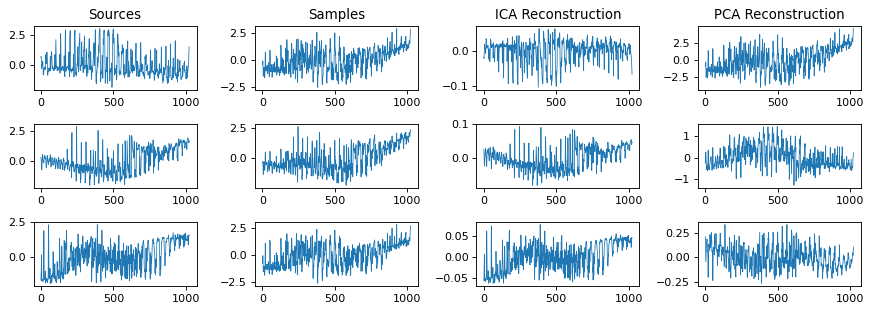

In [6]:
# ICA
ica = FastICA(n_components=3, random_state=1)
recon_sources_ica = ica.fit_transform(samples)  # Reconstruct signals based on independent components
# PCA
pca = PCA(n_components=3, random_state=1)
recon_sources_pca = pca.fit_transform(samples)  # Reconstruct signals based on orthogonal components
# Visualization
fig, axes = plt.subplots(3, 4, figsize=(11, 4), dpi=80)
axes[0, 0].set_title("Sources")
for ax, source in zip(axes[:, 0], sources.T):
    ax.plot(source, linewidth=0.7)
axes[0, 1].set_title("Samples")
for ax, sample in zip(axes[:, 1], samples.T):
    ax.plot(sample, linewidth=0.7)
axes[0, 2].set_title("ICA Reconstruction")
for ax, recon_ica in zip(axes[:, 2], recon_sources_ica.T):
    ax.plot(recon_ica, linewidth=0.7)
axes[0, 3].set_title("PCA Reconstruction")
for ax, recon_pca in zip(axes[:, 3], recon_sources_pca.T):
    ax.plot(recon_pca, linewidth=0.7)
plt.tight_layout()
plt.show()

A continuación, se muestran las reconstrucciones como imágenes para que usted pueda reconocer fácilmente a qué fuente corresponde cada reconstrucción y las posibles inversiones de color en la salida de ICA o PCA.

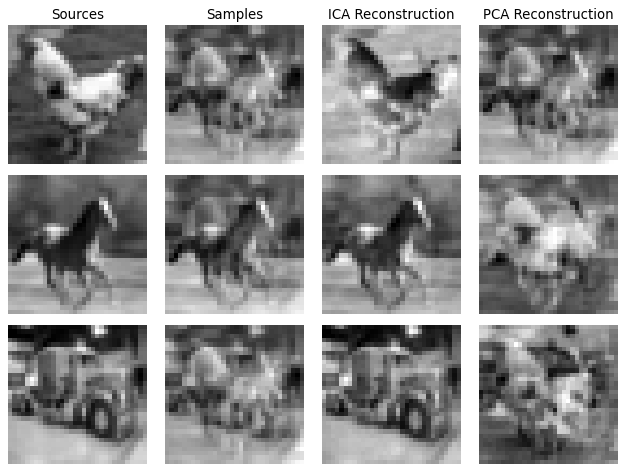

In [7]:
fig, axes = plt.subplots(3, 4, figsize=(8, 6), dpi=80)
axes[0, 0].set_title("Sources")
for ax, source in zip(axes[:, 0], sources.T):
    ax.imshow(source.reshape(32, 32), cmap="gray")
axes[0, 1].set_title("Samples")
for ax, sample in zip(axes[:, 1], samples.T):
    ax.imshow(sample.reshape(32, 32), cmap="gray")
axes[0, 2].set_title("ICA Reconstruction")
for ax, recon_ica in zip(axes[:, 2], recon_sources_ica.T):
    ax.imshow(recon_ica.reshape(32, 32), cmap="gray")
axes[0, 3].set_title("PCA Reconstruction")
for ax, recon_pca in zip(axes[:, 3], recon_sources_pca.T):
    ax.imshow(recon_pca.reshape(32, 32), cmap="gray")
[ax.axis("off") for ax in axes.flatten()]
plt.tight_layout()
plt.show()

<h2>Matriz de correlación y alineamiento de reconstrucciones</h2>

Usted debe cuantificar el desempeño con la ayuda de la matriz de correlación entre las fuentes originales y las reconstrucciones, dada por:
$$
\mathbf{C}(\mathbf{S}, \mathbf{\hat{S}}) = \begin{bmatrix}
\mathrm{corr}(s_1,\hat{s}_1) & \mathrm{corr}(s_1,\hat{s}_2) & \mathrm{corr}(s_1,\hat{s}_3) \\
\mathrm{corr}(s_2,\hat{s}_1) & \mathrm{corr}(s_2,\hat{s}_2) & \mathrm{corr}(s_2,\hat{s}_3) \\
\mathrm{corr}(s_3,\hat{s}_1) & \mathrm{corr}(s_3,\hat{s}_2) & \mathrm{corr}(s_3,\hat{s}_3) \\
\end{bmatrix}.
$$

Si $s_i$ es reconstruido perfectamente por $\hat{s}_j$, entonces $\mathrm{corr}(s_i,\hat{s}_j)$ será igual a $\pm 1$ (recuerde que el signo de la reconstrucción es irrelevante). Si por el contrario las variables están descorrelacionadas, entonces $\mathrm{corr}(s_i,\hat{s}_j)=0$.

A continuación, se muestran las matrices de correlación para ICA y PCA.

In [8]:
def compute_correlation(sources, reconstructions):
    n_vars = sources.shape[1]
    correlation = np.corrcoef(sources, reconstructions, rowvar=False)[0:n_vars, n_vars:]
    return correlation

corr_matrix_ica = compute_correlation(sources, recon_sources_ica)
corr_matrix_pca = compute_correlation(sources, recon_sources_pca)
print("ICA Correlation Matrix (sources vs reconstructions)")
print(corr_matrix_ica)
print("")
print("PCA Correlation Matrix (sources vs reconstructions)")
print(corr_matrix_pca)

ICA Correlation Matrix (sources vs reconstructions)
[[-0.95928596 -0.22658585 -0.16558985]
 [ 0.07684219  0.96541392  0.24899966]
 [-0.03349749  0.06777977  0.9967348 ]]

PCA Correlation Matrix (sources vs reconstructions)
[[ 0.18805346  0.73980861  0.64522074]
 [ 0.66933883 -0.73197142  0.12701493]
 [ 0.7578667   0.15836012 -0.63226302]]


Note que la matriz de correlación de ICA contiene muy buenas correlaciones en las entradas de la matriz en donde se encuentran las correspondencias entre fuente y reconstrucción identificadas visualmente en las imágenes. Dichas entradas no están concentradas en la diagonal de $\mathbf{C}$ ya que $s_i$ no es en general reconstruido por $\hat{s}_i$ sino que por alguna otra salida. Si bien esta situación es esperable, es mejor alinear las reconstrucciones para facilitar la cuantificación del desempeño. Es decir, que $s_i$ sea reconstruido por $\hat{s}_i$.

Se les provee un pequeño algoritmo que alinea las reconstrucciones por usted buscando iterativamente las mejores correlaciones en la matriz de correlación. De paso, también se corrige el signo de la salida para que $\mathrm{corr}(s_i,\hat{s}_i)$ sea positivo. Esto permite que no hayan inversiones de color en las reconstrucciones.

In [9]:
def alignment_algorithm(sources, reconstructions):
    correlation = compute_correlation(sources, reconstructions)
    # Find permutation that allows alignment between reconstructions and sources
    n_vars = sources.shape[1]
    abs_corr = np.abs(correlation)
    aligned_columns = [None] * n_vars
    for i in range(n_vars):
        idx = np.argmax(abs_corr)
        col = idx % n_vars
        row = idx // n_vars
        aligned_columns[row] = col
        abs_corr[row, :] = 0
        abs_corr[:,  col] = 0
    # Align reconstructions and give them proper sign
    aligned_reconstructions = []
    for i in range(n_vars):
        col = aligned_columns[i]
        correcting_sign = np.sign(correlation[i, col])
        aligned_recon = correcting_sign * reconstructions[:, col]
        aligned_reconstructions.append(aligned_recon)
    aligned_reconstructions = np.stack(aligned_reconstructions, axis=1)
    return aligned_reconstructions


recon_sources_ica_aligned = alignment_algorithm(sources, recon_sources_ica)
recon_sources_pca_aligned = alignment_algorithm(sources, recon_sources_pca)
corr_matrix_ica_aligned = compute_correlation(sources, recon_sources_ica_aligned)
corr_matrix_pca_aligned = compute_correlation(sources, recon_sources_pca_aligned)
print("ICA Correlation Matrix (sources vs reconstructions) -- ALIGNED")
print(corr_matrix_ica_aligned)
print("")
print("PCA Correlation Matrix (sources vs reconstructions) -- ALIGNED")
print(corr_matrix_pca_aligned)

ICA Correlation Matrix (sources vs reconstructions) -- ALIGNED
[[ 0.95928596 -0.22658585 -0.16558985]
 [-0.07684219  0.96541392  0.24899966]
 [ 0.03349749  0.06777977  0.9967348 ]]

PCA Correlation Matrix (sources vs reconstructions) -- ALIGNED
[[ 0.73980861  0.64522074  0.18805346]
 [-0.73197142  0.12701493  0.66933883]
 [ 0.15836012 -0.63226302  0.7578667 ]]


Vea ahora las imágenes alineadas y sin inversiones de color. Es mucho más clara la superioridad de ICA en la descomposición.

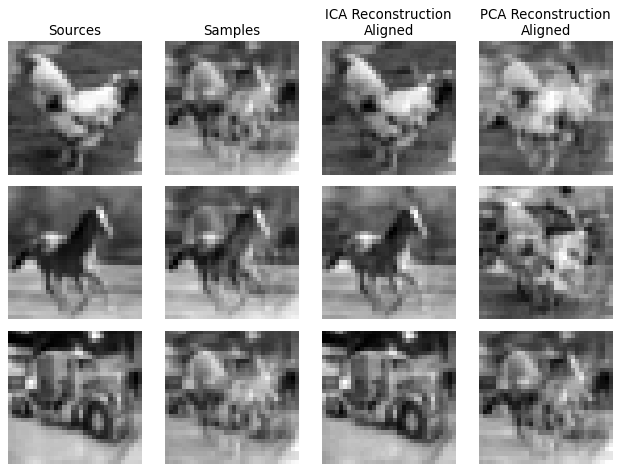

In [10]:
fig, axes = plt.subplots(3, 4, figsize=(8, 6), dpi=80)
axes[0, 0].set_title("Sources")
for ax, source in zip(axes[:, 0], sources.T):
    ax.imshow(source.reshape(32, 32), cmap="gray")
axes[0, 1].set_title("Samples")
for ax, sample in zip(axes[:, 1], samples.T):
    ax.imshow(sample.reshape(32, 32), cmap="gray")
axes[0, 2].set_title("ICA Reconstruction\nAligned")
for ax, recon_ica in zip(axes[:, 2], recon_sources_ica_aligned.T):
    ax.imshow(recon_ica.reshape(32, 32), cmap="gray")
axes[0, 3].set_title("PCA Reconstruction\nAligned")
for ax, recon_pca in zip(axes[:, 3], recon_sources_pca_aligned.T):
    ax.imshow(recon_pca.reshape(32, 32), cmap="gray")
[ax.axis("off") for ax in axes.flatten()]
plt.tight_layout()
plt.show()

<h2>Métrica de desempeño</h2>

Para sus experimentos, lo anterior no basta. En Inteligencia Computacional, el desarrollo de modelos es mucho más propicio cuando existe una métrica escalar que se desea optimizar. Por el momento solo tenemos una matriz ¿Qué escalar se puede utilizar? En un caso ideal, la matriz de correlación alineada $\mathbf{C}_{aligned}\in\mathbb{R}^{3\times 3}$ tendrá entradas en su diagonal exactamente iguales a 1. Podemos aprovechar esto para definir una métrica escalar simple, que llamaremos DISS (por "dissimilarity"):
$$ 
\mathrm{DISS} := \sqrt{
\frac{1}{3} \sum_{i=1}^3 (1 - (\mathbf{C}_{aligned})_{ii})^2
}
$$
Se cumple que $\mathrm{DISS}\in[0, 1]$, siendo DISS=0 el caso idealizado, mientras que un DISS de mayor magnitud implica menor calidad de reconstrucción. De esta forma, un buen modelo tiene bajo DISS. 

A continuación se muestra el DISS para ICA y PCA. Como referencia, también se muestra el desempeño de:
- Caso sin descomposición: Usar directamente las observaciones $\mathbf{X}$.
- Mejor descomposición posible: Usar la inversa de la generación de observaciones $\mathbf{S} + \mathbf{N}(\mathbf{A^\top})^{-1}$.

Note que incluso en el mejor caso DISS es distinto de cero debido al ruido.

In [11]:
def compute_dissimilarity(sources, reconstructions):
    aligned_reconstructions = alignment_algorithm(sources, reconstructions)
    correlation = compute_correlation(sources, aligned_reconstructions)
    dissimilarity = np.sqrt(np.mean((1 - np.diag(correlation)) ** 2))
    return dissimilarity


diss_ica = compute_dissimilarity(sources, recon_sources_ica)
diss_pca = compute_dissimilarity(sources, recon_sources_pca)
print("DISS = %1.6f using ICA." % diss_ica)
print("DISS = %1.6f using PCA." % diss_pca)
# No descomposition
diss_x = compute_dissimilarity(sources, samples)
print("DISS = %1.6f using observations X directly." % diss_x)
# Best case possible
best_case_possible = sources + np.matmul(noise, np.linalg.inv(A.T))
diss_best = compute_dissimilarity(sources, best_case_possible)
print("DISS = %1.6f using best case possible." % diss_best)

DISS = 0.030900 using ICA.
DISS = 0.544191 using PCA.
DISS = 0.412767 using observations X directly.
DISS = 0.000374 using best case possible.


<h2>Implementación del modelo ECR</h2>

Sea $x_t=[x_1(t),\ x_2(t),\ x_3(t)]$ e $y_t=[y_1(t),\ y_2(t),\ y_3(t)]$. Usted debe implementar un modelo de descomposición lineal $y_t = Wx_t$ con $W\in\mathbb{R}^{3\times 3}$, tal que la reconstrucción del modelo $y_t$ maximice la ECR. Sin embargo, dado que maximizar la ECR es equivalente a minimizar el potencial de información, usted debe entrenar el modelo para minimizar el potencial de información. 

Agrupemos todas las reconstrucciones en una matriz $\mathbf{Y}\in\mathbb{R}^{T\times 3}$ de forma análoga a $\mathbf{X}$ y $\mathbf{S}$. Para obtener el potencial de información en cada iteración del modelo, usted debe hacer lo siguiente:
- Normalizar cada dimensión de salida, para tener media cero y varianza unitaria sobre las $T$ muestras. Esto transformará la matriz $\mathbf{Y}$ en una matriz normalizada $\mathbf{\tilde{Y}}$.
- Calcular el potencial de información como:
$$\widehat{V}_\sigma(\mathbf{\tilde{Y}}) = \frac{1}{T^2} \sum_{i=1}^T \sum_{j=1}^T \frac{1}{\left(2\pi\sigma^2\right)^{3/2}} \exp \left( -\frac{1}{2\sigma^2} \sum_{d=1}^3(\mathbf{\tilde{Y}}_{id} - \mathbf{\tilde{Y}}_{jd})^2\right),
$$
donde $\sigma$ es el ancho de banda del kernel gaussiano.

El uso de la matriz $\mathbf{\tilde{Y}}$ en lugar de la matriz $\mathbf{Y}$ en el cálculo del potencial de información evita que el modelo minimice el IP simplemente re-escalando las salidas.

Especificaciones del modelo:
- Funcional a minimizar: Potencial de información sobre las salidas normalizadas del modelo.
- Optimizador: Adam con tasa de aprendizaje 0.03 y decaimientos $\beta_{1}=0.9$ y $\beta_{2}=0.999$.
- Entrenamiento por 30,000 épocas.

Instrucciones de programación:
- Es libre de elegir la librería de su preferencia para implementar el modelo. Se recomienda Tensorflow o Pytorch.
- Debe implementar su modelo en una clase llamada "EntropyModel". 
- La clase debe implementar un método "fit" para entrenar en datos $\mathbf{X}\in\mathbb{R}^{T\times 3}$ y evaluar el DISS en las fuentes $\mathbf{S}$. Al entrenar el modelo, se debe entregar la evolución de la entropía y el DISS a lo largo de las épocas.
- La clase debe implementar un método "transform" para reconstruir las señales.
- Es libre de implementar métodos adicionales si lo desea.

Implemente su modelo en la siguiente celda. Sea ordenado y claro en su código. Comente adecuadamente. Elija nombres significativos para sus variables.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
class EntropyModel(nn.Module):
    def __init__(
        self,
        kernel_width,
        learning_rate=0.03,
        n_epochs=30000,
        n_inputs=3,
        n_outputs=3
    ):
        super(EntropyModel, self).__init__()

        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.kernel_width = kernel_width
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        # --- Your code goes here ---

        self.W = nn.Linear(self.n_inputs, self.n_outputs,bias=False)

        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999))

    def forward(self, x):
        x = self.W(x)

        return x

    def compute_potential_information(self, Y, sigma):
        Y_normalized = (Y - Y.mean(dim=0)) / Y.std(dim=0)
        
        # Calculate pairwise distances between all points
        dists = torch.cdist(Y_normalized, Y_normalized, p=2)
        
        # Calculate PI by taking the mean of the exponential of squared distances
        PI = torch.exp(-dists**2 / (2 * sigma**2)).mean()
        
        # Normalize PI
        PI /= (2 * np.pi * sigma**2)**(3/2)
        
        return PI

        
    def fit(self, x, sources):
        # --- Your code goes here ---
        x = torch.tensor(x, dtype=torch.float32)
        sources = torch.tensor(sources, dtype=torch.float32)
        
        PI_history = []
        entropy_history = []
        DISS_history = []
        
        progress_bar = tqdm(range(self.n_epochs))

        for epoch in progress_bar:
            self.optimizer.zero_grad()
            
            reconstructions = self.forward(x)

            PI = self.compute_potential_information(reconstructions, self.kernel_width)
            
            # Convert torch tensor to numpy for DISS computation
            reconstructions_np = reconstructions.detach().cpu().numpy()
            sources_np = sources.cpu().numpy()
            DISS = compute_dissimilarity(sources_np, reconstructions_np)
            
            loss = PI
            loss.backward()
            self.optimizer.step()
            
            PI_history.append(PI.item())
            entropy_history.append(-torch.log(PI).item())
            DISS_history.append(DISS)
            
            progress_bar.set_description(f"PI: {PI.item():.4f} - DISS: {DISS:.4f}")

        return PI_history,entropy_history, DISS_history
    
    def transform(self, x):
        # --- Your code goes here ---
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            reconstructions = self.forward(x)
        return reconstructions.numpy()

<h2>Entrenamiento del modelo ECR</h2>

Experimente con anchos de banda $\sigma\in\{1,\ 0.5,\ 0.1\}$. Para cada ancho de banda, realice 10 entrenamientos con inicializaciones aleatorias y reporte:
- El gráfico de entropía promedio con su respectiva desviación estándar a lo largo de las épocas.
- El gráfico de DISS promedio con su respectiva desviación estándar a lo largo de las épocas.
- El promedio y desviación estándar del DISS final.

Comente y explique sus resultados. ¿Qué efecto tiene el ancho de banda?

<font color='red'>Respuesta:</font> 

Training for σ=1
Training iteration 1/10


PI: 0.0125 - DISS: 0.2347: 100%|██████████| 30000/30000 [04:19<00:00, 115.65it/s]


Training iteration 2/10


PI: 0.0125 - DISS: 0.2341: 100%|██████████| 30000/30000 [04:19<00:00, 115.59it/s]


Training iteration 3/10


PI: 0.0125 - DISS: 0.2364: 100%|██████████| 30000/30000 [04:18<00:00, 116.01it/s]


Training iteration 4/10


PI: 0.0125 - DISS: 0.2372: 100%|██████████| 30000/30000 [04:04<00:00, 122.80it/s]


Training iteration 5/10


PI: 0.0125 - DISS: 0.2357: 100%|██████████| 30000/30000 [04:10<00:00, 119.62it/s]


Training iteration 6/10


PI: 0.0125 - DISS: 0.2357: 100%|██████████| 30000/30000 [04:11<00:00, 119.50it/s]


Training iteration 7/10


PI: 0.0125 - DISS: 0.2494: 100%|██████████| 30000/30000 [04:09<00:00, 120.29it/s]


Training iteration 8/10


PI: 0.0125 - DISS: 0.2393: 100%|██████████| 30000/30000 [04:07<00:00, 121.18it/s]


Training iteration 9/10


PI: 0.0125 - DISS: 0.2406: 100%|██████████| 30000/30000 [04:07<00:00, 121.23it/s]


Training iteration 10/10


PI: 0.0125 - DISS: 0.2340: 100%|██████████| 30000/30000 [03:58<00:00, 125.83it/s]


Training for σ=0.5
Training iteration 1/10


PI: 0.0261 - DISS: 0.2202: 100%|██████████| 30000/30000 [03:55<00:00, 127.16it/s]


Training iteration 2/10


PI: 0.0261 - DISS: 0.1338: 100%|██████████| 30000/30000 [03:57<00:00, 126.13it/s]


Training iteration 3/10


PI: 0.0261 - DISS: 0.2371: 100%|██████████| 30000/30000 [03:56<00:00, 126.61it/s]


Training iteration 4/10


PI: 0.0261 - DISS: 0.2459: 100%|██████████| 30000/30000 [03:55<00:00, 127.39it/s]


Training iteration 5/10


PI: 0.0261 - DISS: 0.2729: 100%|██████████| 30000/30000 [03:55<00:00, 127.46it/s]


Training iteration 6/10


PI: 0.0261 - DISS: 0.2710: 100%|██████████| 30000/30000 [03:45<00:00, 132.75it/s]


Training iteration 7/10


PI: 0.0261 - DISS: 0.1386: 100%|██████████| 30000/30000 [03:27<00:00, 144.42it/s]


Training iteration 8/10


PI: 0.0261 - DISS: 0.3816: 100%|██████████| 30000/30000 [03:24<00:00, 146.55it/s]


Training iteration 9/10


PI: 0.0261 - DISS: 0.1816: 100%|██████████| 30000/30000 [03:23<00:00, 147.68it/s]


Training iteration 10/10


PI: 0.0261 - DISS: 0.2612: 100%|██████████| 30000/30000 [03:26<00:00, 145.50it/s]


Training for σ=0.1
Training iteration 1/10


PI: 0.1340 - DISS: 0.1406: 100%|██████████| 30000/30000 [05:56<00:00, 84.05it/s]


Training iteration 2/10


PI: 0.1340 - DISS: 0.2549: 100%|██████████| 30000/30000 [05:54<00:00, 84.64it/s]


Training iteration 3/10


PI: 0.1340 - DISS: 0.1365: 100%|██████████| 30000/30000 [05:55<00:00, 84.32it/s]


Training iteration 4/10


PI: 0.1340 - DISS: 0.3718: 100%|██████████| 30000/30000 [05:53<00:00, 84.98it/s]


Training iteration 5/10


PI: 0.1340 - DISS: 0.3654: 100%|██████████| 30000/30000 [06:06<00:00, 81.85it/s]


Training iteration 6/10


PI: 0.1340 - DISS: 0.2173: 100%|██████████| 30000/30000 [06:01<00:00, 83.00it/s]


Training iteration 7/10


PI: 0.1340 - DISS: 0.3746: 100%|██████████| 30000/30000 [05:50<00:00, 85.56it/s]


Training iteration 8/10


PI: 0.1340 - DISS: 0.1691: 100%|██████████| 30000/30000 [05:51<00:00, 85.42it/s]


Training iteration 9/10


PI: 0.1341 - DISS: 0.3608: 100%|██████████| 30000/30000 [05:51<00:00, 85.38it/s]


Training iteration 10/10


PI: 0.1340 - DISS: 0.3935: 100%|██████████| 30000/30000 [05:48<00:00, 86.01it/s]


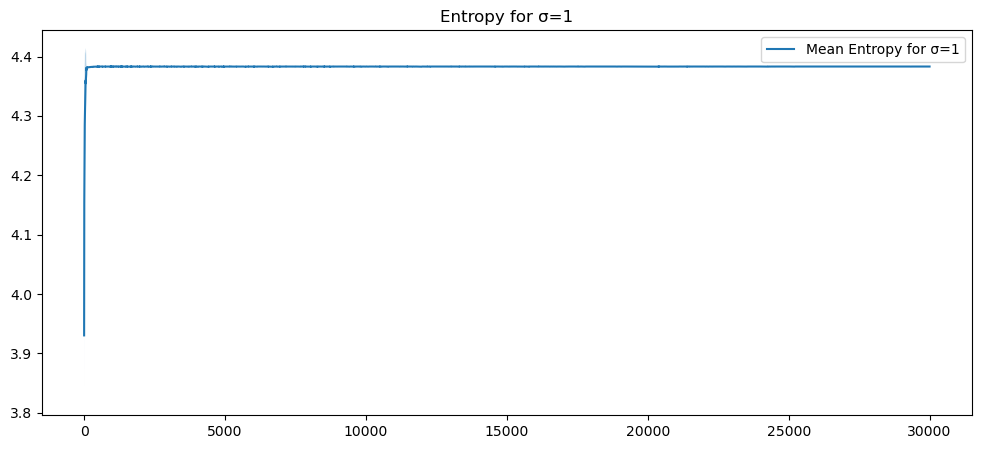

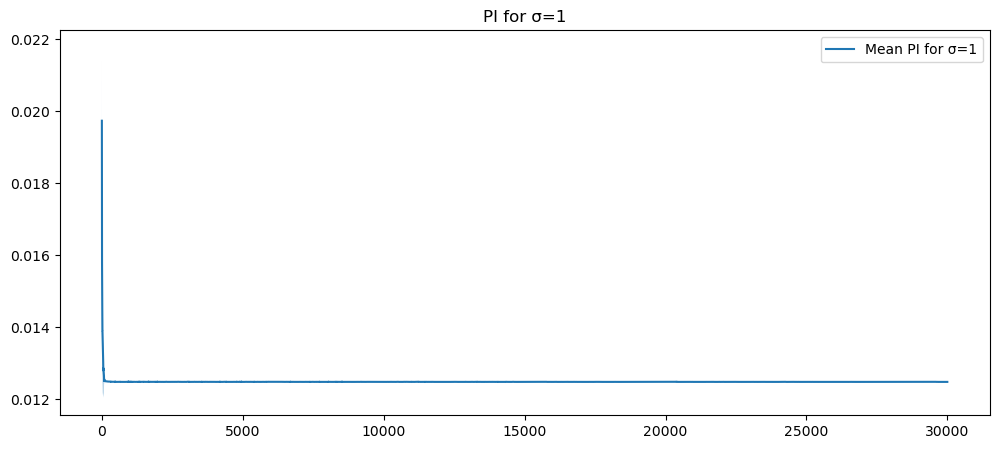

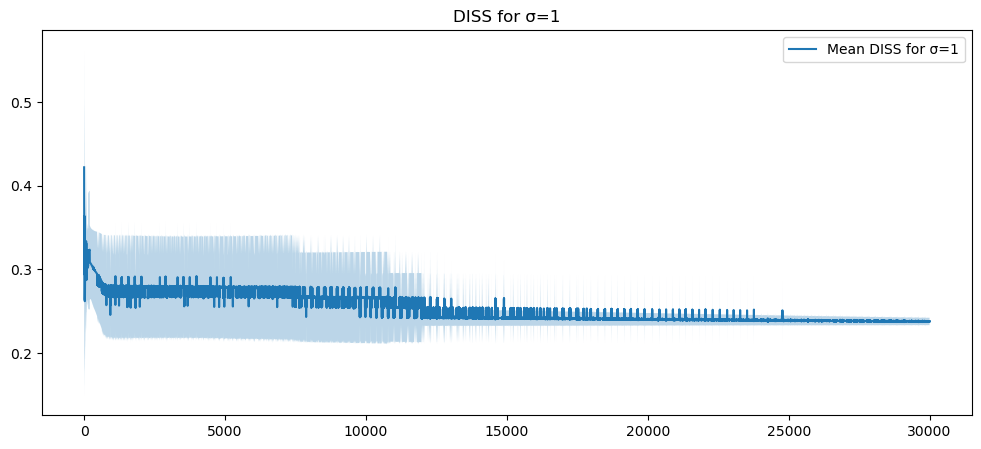

Statistics for σ=1:
Mean final DISS: 0.2377
Standard deviation of final DISS: 0.0044
----------------------------------------


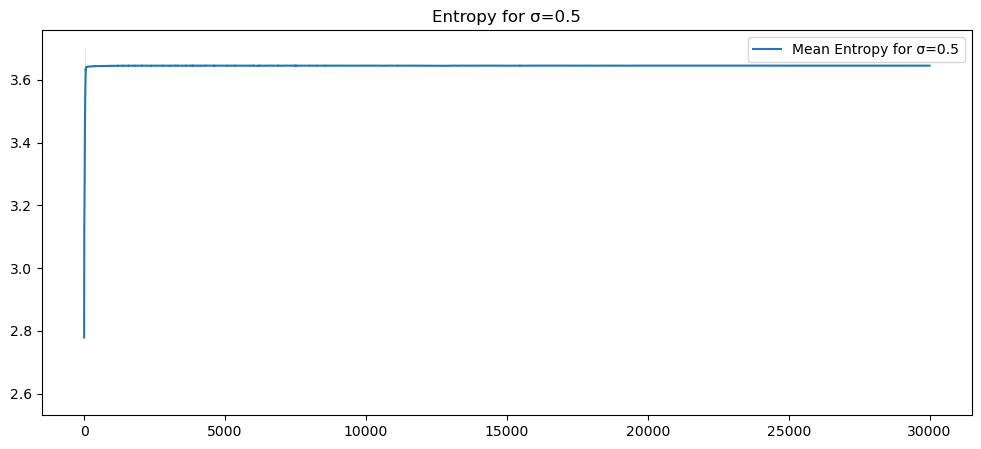

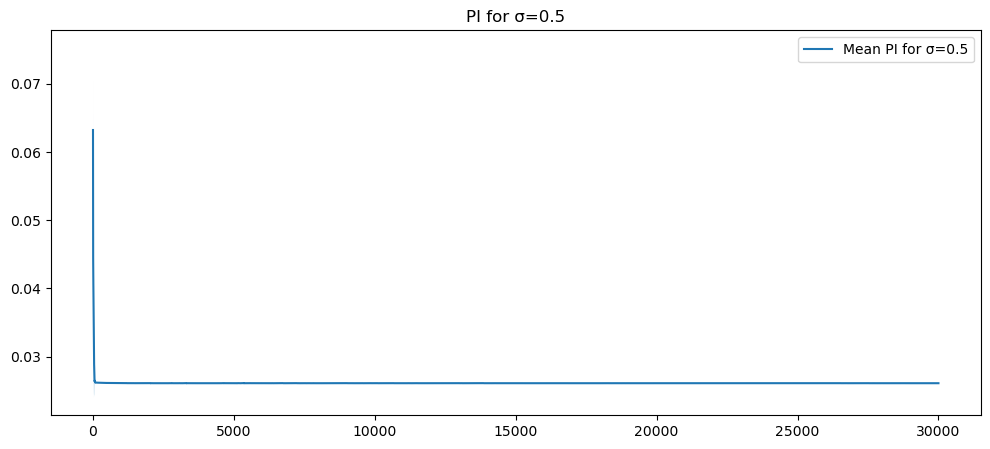

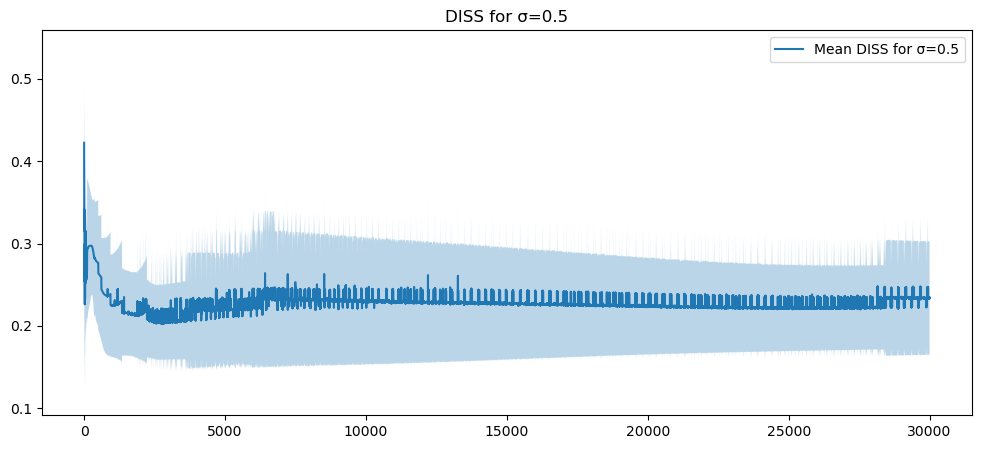

Statistics for σ=0.5:
Mean final DISS: 0.2344
Standard deviation of final DISS: 0.0690
----------------------------------------


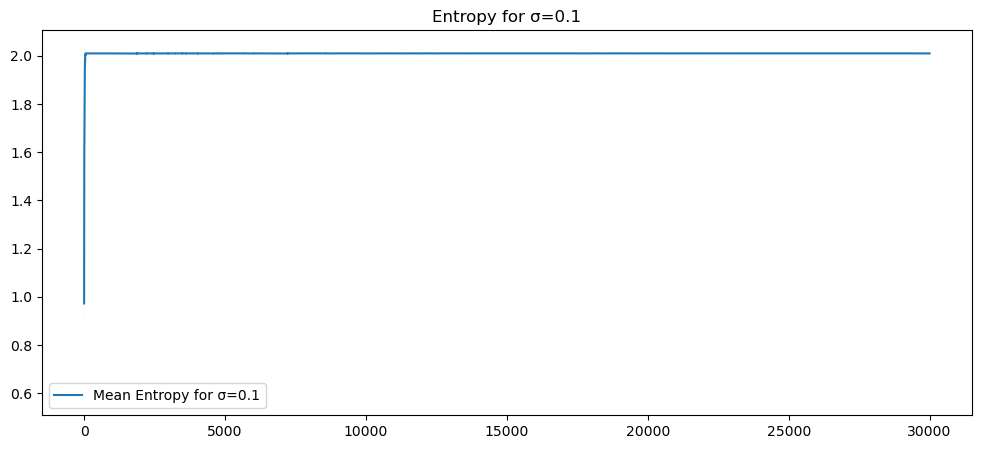

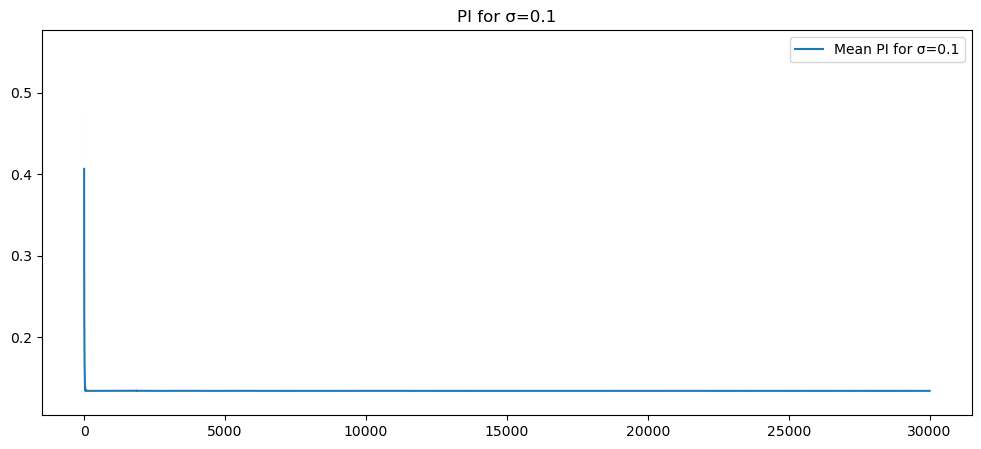

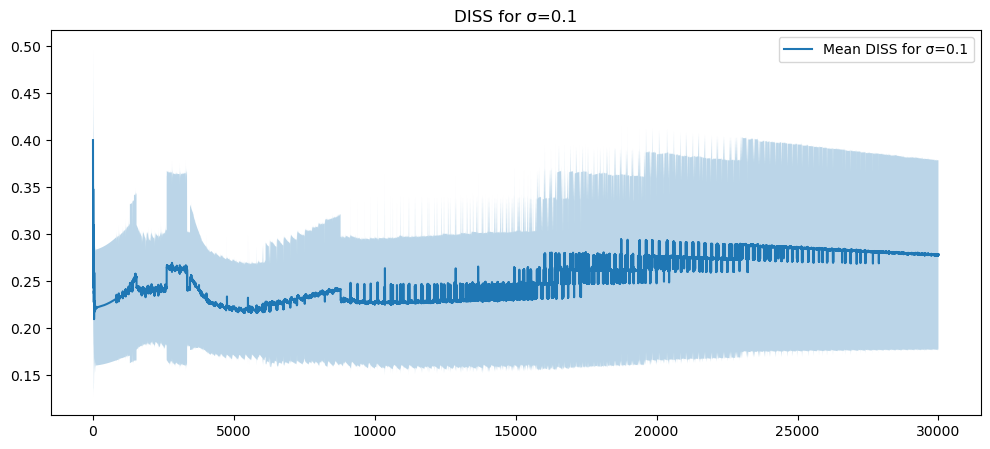

Statistics for σ=0.1:
Mean final DISS: 0.2784
Standard deviation of final DISS: 0.1005
----------------------------------------


In [13]:
X_train = samples
S_sources = sources

# List of bandwidths
sigmas = [1, 0.5, 0.1]

# Store results
all_entropy_histories = {}
all_diss_histories = {}
all_PI_histories = {}

for sigma in sigmas:
    print(f"Training for σ={sigma}")
    entropy_histories = []
    PI_histories = []
    diss_histories = []
    
    for i in range(10):
        print(f"Training iteration {i+1}/10")
        
        # Create and train the model
        model = EntropyModel(kernel_width=sigma)
        PI_history,entropy_history, diss_history = model.fit(X_train, S_sources)
        torch.save(model.state_dict(), f"model_{sigma}_{i+1}.pt")
        
        entropy_histories.append(entropy_history)
        PI_histories.append(PI_history)
        diss_histories.append(diss_history)
    
    # Store results for this sigma
    all_entropy_histories[sigma] = entropy_histories
    all_PI_histories[sigma]= PI_histories
    all_diss_histories[sigma] = diss_histories


# Plotting the results
for sigma in sigmas:
    # Entropy plot
    entropies = np.array(all_entropy_histories[sigma])
    mean_entropy = np.mean(entropies, axis=0)
    std_entropy = np.std(entropies, axis=0)
    
    plt.figure(figsize=(12, 5))
    plt.fill_between(range(len(mean_entropy)), mean_entropy-std_entropy, mean_entropy+std_entropy, alpha=0.3)
    plt.plot(mean_entropy, label=f"Mean Entropy for σ={sigma}")
    plt.legend()
    plt.title(f"Entropy for σ={sigma}")
    plt.show()
    
    # PI plot
    PI_histories = np.array(all_PI_histories[sigma])  # Add this line to get PI histories
    mean_PI = np.mean(PI_histories, axis=0)
    std_PI = np.std(PI_histories, axis=0)
    
    plt.figure(figsize=(12, 5))
    plt.fill_between(range(len(mean_PI)), mean_PI - std_PI, mean_PI + std_PI, alpha=0.3)
    plt.plot(mean_PI, label=f"Mean PI for σ={sigma}")
    plt.legend()
    plt.title(f"PI for σ={sigma}")
    plt.show()
    
    # DISS plot
    disses = np.array(all_diss_histories[sigma])
    mean_diss = np.mean(disses, axis=0)
    std_diss = np.std(disses, axis=0)
    
    plt.figure(figsize=(12, 5))
    plt.fill_between(range(len(mean_diss)), mean_diss-std_diss, mean_diss+std_diss, alpha=0.3)
    plt.plot(mean_diss, label=f"Mean DISS for σ={sigma}")
    plt.legend()
    plt.title(f"DISS for σ={sigma}")
    plt.show()


    # Print final DISS statistics
    final_diss = disses[:, -1]
    print(f"Statistics for σ={sigma}:")
    print(f"Mean final DISS: {np.mean(final_diss):.4f}")
    print(f"Standard deviation of final DISS: {np.std(final_diss):.4f}")
    print("-"*40)


Se observa que con todos los valores de ancho de banda se logra minimizar el PI, sin embargo al observar el gráfico de DISS se destaca la diferencia de convergencia con distintos valores, se observa por ejemplo que con $\sigma=1.0$ la desviación estandar es muy pequeña y la mayoría de las corridas convergen cercanos al promedio, a diferencia de $\sigma=0.5$ y $\sigma=0.1$, donde se aprecia mediante la desviación estandar la gran diferencia en el valor alcanzado por cada corrida, sobretodo para $\sigma=0.1$.  El valor del ancho de banda controla cuánto se suavizan los datos y, por lo tanto, afecta la forma y la precisión de la aproximación de la PDF, esto repercute en la desviación estandar de las diferentes corridas. Con $\sigma = 0.5$ Se obtiene el mejor promedio además de una desviación estandar mayor que la de $\sigma=1.0$ lo cual permite explorar otras configuraciones y llegar a mejores resultados.

Seleccione el mejor ancho de banda encontrado. Para dicho ancho de banda, seleccione el entrenamiento que obtiene un DISS igual a la mediana de todas las corridas (caso representativo) y el entrenamiento que obtiene el menor DISS de las corridas (mejor caso). Compare las reconstrucciones de ambos casos con las obtenidas por ICA y PCA a través de las imágenes y las matrices de correlación (resultados alineados). Discuta sobre la estabilidad de su modelo a la inicialización de los pesos y sobre la calidad de la descomposición alcanzada, explicando las diferencias observadas.

<font color='red'>Respuesta:</font> 

In [20]:
sigma=0.5
disses = np.array(all_diss_histories[sigma])
final_diss = disses[:, -1]
print(f"Statistics for σ={sigma}:")
print(f"DISS mediana: {np.median(final_diss)}")
#minimum diss value
print(f"DISS mínima: {min(final_diss)}")
print("")
print(f"DISS finales: {final_diss}")
final_diss.sort()
print("")
print(f"DISS finales ordenadas: {final_diss}")

Statistics for σ=0.5:
DISS mediana: 0.24153726148261156
DISS mínima: 0.13376040460091287

DISS finales: [0.22023084 0.1337604  0.23713277 0.24594175 0.27285184 0.27098128
 0.13863713 0.38163868 0.18162919 0.26124135]

DISS finales ordenadas: [0.1337604  0.13863713 0.18162919 0.22023084 0.23713277 0.24594175
 0.26124135 0.27098128 0.27285184 0.38163868]


DISS igual a la mediana de todas las corridas

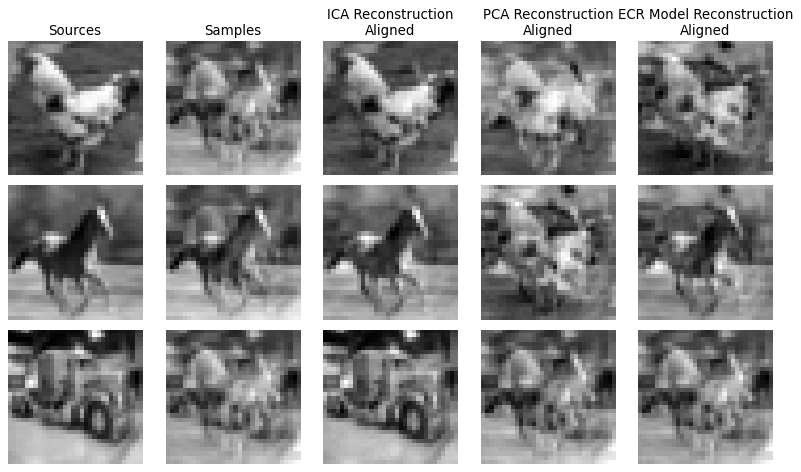

DISS = 0.030900 using ICA.
DISS = 0.544191 using PCA.
DISS = 0.272852 using ECR Model.

ICA Correlation Matrix (sources vs reconstructions) -- ALIGNED
[[ 0.95928596 -0.22658585 -0.16558985]
 [-0.07684219  0.96541392  0.24899966]
 [ 0.03349749  0.06777977  0.9967348 ]]

PCA Correlation Matrix (sources vs reconstructions) -- ALIGNED
[[ 0.73980861  0.64522074  0.18805346]
 [-0.73197142  0.12701493  0.66933883]
 [ 0.15836012 -0.63226302  0.7578667 ]]

ECR Model Correlation Matrix (sources vs reconstructions) -- ALIGNED
[[ 0.76061786 -0.33738898  0.36499684]
 [-0.16697419  0.83636193  0.55282341]
 [-0.69651122 -0.25365599  0.7091161 ]]


In [22]:
model= EntropyModel(kernel_width=0.5)

# Load the model state_dict()
model.load_state_dict(torch.load('model_0.5_3.pt'))

# Transform the samples using the loaded model
reconstructions = model.transform(samples)
recon_sources_model_aligned = alignment_algorithm(sources, reconstructions)

fig, axes = plt.subplots(3, 5, figsize=(10, 6), dpi=80) 

# Plotting the sources
axes[0, 0].set_title("Sources")
for ax, source in zip(axes[:, 0], sources.T):
    ax.imshow(source.reshape(32, 32), cmap="gray")

# Plotting the samples
axes[0, 1].set_title("Samples")
for ax, sample in zip(axes[:, 1], samples.T):
    ax.imshow(sample.reshape(32, 32), cmap="gray")

# Plotting the ICA Reconstruction
axes[0, 2].set_title("ICA Reconstruction\nAligned")
for ax, recon_ica in zip(axes[:, 2], recon_sources_ica_aligned.T):
    ax.imshow(recon_ica.reshape(32, 32), cmap="gray")

# Plotting the PCA Reconstruction
axes[0, 3].set_title("PCA Reconstruction\nAligned")
for ax, recon_pca in zip(axes[:, 3], recon_sources_pca_aligned.T):
    ax.imshow(recon_pca.reshape(32, 32), cmap="gray")

# Plotting the model reconstructions
axes[0, 4].set_title("ECR Model Reconstruction\nAligned")
for ax, recon in zip(axes[:, 4], recon_sources_model_aligned.T):
    ax.imshow(recon.reshape(32, 32), cmap="gray")

# Turn off axis for all plots
[ax.axis("off") for ax in axes.flatten()]

plt.tight_layout()
plt.show()

diss_ica = compute_dissimilarity(sources, recon_sources_ica)
diss_pca = compute_dissimilarity(sources, recon_sources_pca)
print("DISS = %1.6f using ICA." % diss_ica)
print("DISS = %1.6f using PCA." % diss_pca)
print("DISS = %1.6f using ECR Model." % final_diss[8])
print("")

corr_matrix_ica_aligned = compute_correlation(sources, recon_sources_ica_aligned)
corr_matrix_pca_aligned = compute_correlation(sources, recon_sources_pca_aligned)
corr_matrix_ECRmodel_aligned = compute_correlation(sources, recon_sources_model_aligned)
print("ICA Correlation Matrix (sources vs reconstructions) -- ALIGNED")
print(corr_matrix_ica_aligned)
print("")
print("PCA Correlation Matrix (sources vs reconstructions) -- ALIGNED")
print(corr_matrix_pca_aligned)
print("")
print("ECR Model Correlation Matrix (sources vs reconstructions) -- ALIGNED")
print(corr_matrix_ECRmodel_aligned)

Menor DISS de las corridas

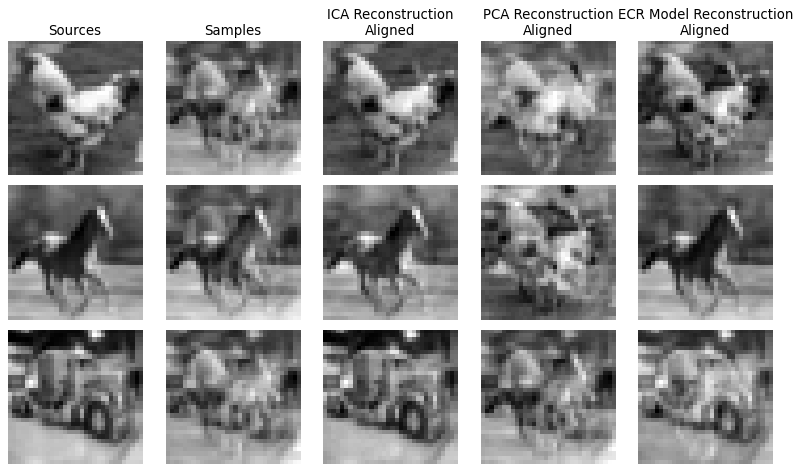

DISS = 0.030900 using ICA.
DISS = 0.544191 using PCA.
DISS = 0.261241 using ECR Model.

ICA Correlation Matrix (sources vs reconstructions) -- ALIGNED
[[ 0.95928596 -0.22658585 -0.16558985]
 [-0.07684219  0.96541392  0.24899966]
 [ 0.03349749  0.06777977  0.9967348 ]]

PCA Correlation Matrix (sources vs reconstructions) -- ALIGNED
[[ 0.73980861  0.64522074  0.18805346]
 [-0.73197142  0.12701493  0.66933883]
 [ 0.15836012 -0.63226302  0.7578667 ]]

ECR Model Correlation Matrix (sources vs reconstructions) -- ALIGNED
[[ 0.80820732 -0.35516285  0.21379494]
 [ 0.21794585  0.98203314 -0.14250023]
 [-0.24165799  0.48358247  0.8714119 ]]


In [23]:
model= EntropyModel(kernel_width=0.1)
# Load the model state_dict()
model.load_state_dict(torch.load('model_0.5_2.pt'))

# Transform the samples using the loaded model
reconstructions = model.transform(samples)
recon_sources_model_aligned = alignment_algorithm(sources, reconstructions)

fig, axes = plt.subplots(3, 5, figsize=(10, 6), dpi=80) 

# Plotting the sources
axes[0, 0].set_title("Sources")
for ax, source in zip(axes[:, 0], sources.T):
    ax.imshow(source.reshape(32, 32), cmap="gray")

# Plotting the samples
axes[0, 1].set_title("Samples")
for ax, sample in zip(axes[:, 1], samples.T):
    ax.imshow(sample.reshape(32, 32), cmap="gray")

# Plotting the ICA Reconstruction
axes[0, 2].set_title("ICA Reconstruction\nAligned")
for ax, recon_ica in zip(axes[:, 2], recon_sources_ica_aligned.T):
    ax.imshow(recon_ica.reshape(32, 32), cmap="gray")

# Plotting the PCA Reconstruction
axes[0, 3].set_title("PCA Reconstruction\nAligned")
for ax, recon_pca in zip(axes[:, 3], recon_sources_pca_aligned.T):
    ax.imshow(recon_pca.reshape(32, 32), cmap="gray")

# Plotting the model reconstructions
axes[0, 4].set_title("ECR Model Reconstruction\nAligned")
for ax, recon in zip(axes[:, 4], recon_sources_model_aligned.T):
    ax.imshow(recon.reshape(32, 32), cmap="gray")

# Turn off axis for all plots
[ax.axis("off") for ax in axes.flatten()]

plt.tight_layout()
plt.show()

diss_ica = compute_dissimilarity(sources, recon_sources_ica)
diss_pca = compute_dissimilarity(sources, recon_sources_pca)
print("DISS = %1.6f using ICA." % diss_ica)
print("DISS = %1.6f using PCA." % diss_pca)
print("DISS = %1.6f using ECR Model." % final_diss[6])
print("")

corr_matrix_ica_aligned = compute_correlation(sources, recon_sources_ica_aligned)
corr_matrix_pca_aligned = compute_correlation(sources, recon_sources_pca_aligned)
corr_matrix_ECRmodel_aligned = compute_correlation(sources, recon_sources_model_aligned)
print("ICA Correlation Matrix (sources vs reconstructions) -- ALIGNED")
print(corr_matrix_ica_aligned)
print("")
print("PCA Correlation Matrix (sources vs reconstructions) -- ALIGNED")
print(corr_matrix_pca_aligned)
print("")
print("ECR Model Correlation Matrix (sources vs reconstructions) -- ALIGNED")
print(corr_matrix_ECRmodel_aligned)

Con $\sigma=0.5$ el modelo logra una estabilidad que permite explorar distintas soluciones con resultados variados manteniendo un buen promedio y buenas corridas, a diferencia de $\sigma=1.0$ con el cual se obtiene una desviación estandar más baja, pero no tan buen promedio, y de $\sigma=0.1$ que obtiene peor promedio y desviación estandar mayor. Se destaca que existe un intercambio entre buen promedio y desviación estandar baja, es clave encontrar un punto que permita tener iteraciones que difieran lo suficiente (desviación estandar considerable) para obtener distintos resultados, pero sin que esto afecte el promedio de forma perjuiciosa.
Se logran mejores descomposiciones con el modelo al comparar con PCA, pero peores que ICA, Al observar la matriz de correlación entre las fuentes y las reconstrucciones, se aprecia la calidad del modelo entrenado, ya que los valores de la diagonal son los más altos y están sobre $0.8$. 